## Installing libraries

In [1]:
#!pip3 install scikit-image
#!pip install efficientnet

In [2]:
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import sys
import os
#import itertools
import random
import shutil # toggle lines in the end of notebook to del all unzipped files
#from skimage import io

import albumentations

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras import optimizers
#from keras.applications import EfficientNetB6
from keras.layers import *
#from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL

# increasing the default size of the charts
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
# graphs in svg look better
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print('Python          :', sys.version.split('\n')[0])
print('Numpy           :', np.__version__)
print('Tensorflow      :', tf.__version__)
print('Keras           :', tf.keras.__version__)
print('Albumentations  :', albumentations.__version__)

Python          : 3.10.10 (tags/v3.10.10:aad5f6a, Feb  7 2023, 17:20:36) [MSC v.1929 64 bit (AMD64)]
Numpy           : 1.23.0
Tensorflow      : 2.11.0
Keras           : 2.11.0
Albumentations  : 1.2.1


In [3]:
# Imports of local libs
sys.path.insert(1, '../')

from utils.read_config import config_reader
from utils.functions import *
from utils.functions_with_keras import *
from utils.model import ModelForTrain
from utils.generators import DataGenerators

In [4]:
# Checking that GPU is working
tf.test.gpu_device_name()

''

## Setup

In [5]:
# In setup, we make the basic settings: it's more convenient to sort them out in the future.
config = config_reader('../config/data_config.json')

input_shape = (config.IMG_SIZE, config.IMG_SIZE, config.IMG_CHANNELS)

paths = create_paths(config, is_notebook=True)

In [6]:
# Fix seed value
seed_value = config.RANDOM_SEED

# 1. Зафиксируем PYTHONHASHSEED для воспроиизводимости результатов обучения модели
os.environ['PYTHONHASHSEED'] = str(seed_value)

# 2. Установим начальное значение для генератора случайных чисел в Python
random.seed(seed_value)

# 3. Установим начальное значение для генератора случайных чисел в Numpy
np.random.seed(seed_value)

# 3. Установим начальное значение для генератора случайных чисел в tensorflow 
tf.random.set_seed(seed_value)

# 4. Конфигурация Tenzorflow
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [7]:
# Setting a specific random seed value for reproducibility
try:
    os.makedirs(paths.PATH_DATA_TRAIN)
    print(f"Directory {paths.PATH_DATA_TRAIN} created")
except FileExistsError:
    print(f"Directory {paths.PATH_DATA_TRAIN} exists")

try:
    os.makedirs(paths.PATH_OUTPUTS)
    print(f"Directory {paths.PATH_OUTPUTS} created")
except FileExistsError:
    print(f"Directory {paths.PATH_OUTPUTS} exists")
    
try:
    os.makedirs(paths.PATH_BEST_MODEL)
    print(f"Directory {paths.PATH_BEST_MODEL} created")
except FileExistsError:
    print(f"Directory {paths.PATH_BEST_MODEL} exists")

try:
    os.makedirs(paths.PATH_MODELS)
    print(f"Directory {paths.PATH_MODELS} created")
except FileExistsError:
    print(f"Directory {paths.PATH_MODELS} exists")

Directory ..\data\inputs_for_train exists
Directory ..\data\outputs_from_train exists
Directory ..\data\best_models exists


In [8]:
# Extract zip archive
print('Zip-archive "sf-dl-car-classification.zip" must be inserted to "data" folder')

# Copy zip archive to folder data
#!gsutil cp gs://oleg-zyablov/skillfactory/sf-dl-car-classification.zip paths.PATH_TO_ZIP

is_true = False
extract_data_from_zip(path_to_big_zip=paths.PATH_TO_ZIP, 
                      path_data_train=paths.PATH_DATA_TRAIN, 
                      is_true=is_true)

Zip-archive "sf-dl-car-classification.zip" must be inserted to "data" folder
Zip-archive "sf-dl-car-classification.zip" no need to unpack, to unpack change value of param "is_true" to "True"


In [9]:
# reading csv data from sf-dl-car-classification.zip
train_df = pd.read_csv(os.path.join(paths.PATH_DATA_TRAIN, "train.csv"))
sample_submission = pd.read_csv(os.path.join(paths.PATH_DATA_TRAIN, "sample-submission.csv"))

## EDA

In [10]:
train_df.head(3)

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0


In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [12]:
train_df.Category.value_counts()

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

### Preliminary conclusion:
In the task block when building the Baseline, it is specified: "The distribution of classes is fairly uniform — that's good." This does not seem to be true, since there is a difference of more than 30% in the amount of data for individual classes in the training sample. You can upload data from other sources for a more even distribution of classes.

Picture examples (random sample)


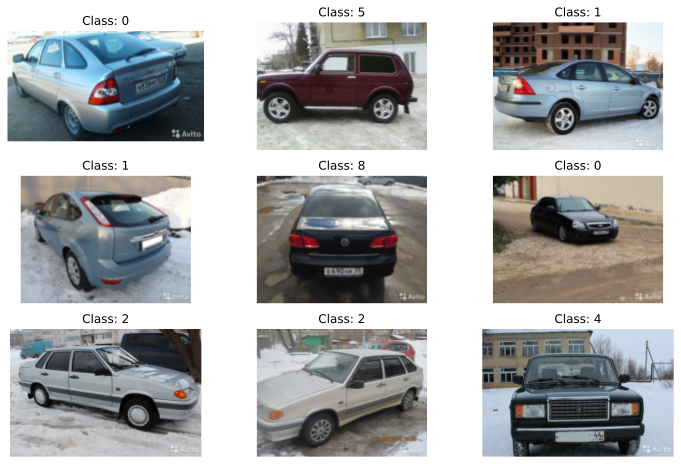

In [13]:
print('Picture examples (random sample)')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(os.path.join(paths.PATH_DATA_TRAIN, 
                                     f'train/{random_image_cat[index]}/{path}'))
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

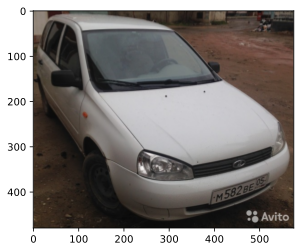

(576, 480)

In [14]:
# An example of a picture with dimensions to understand how best to process and compress images
random_img_path = random.choice(glob(os.path.join(paths.PATH_TO_DATA_TRAIN, '*', '*')))
image = PIL.Image.open(random_img_path)
imgplot = plt.imshow(image)
plt.show()
image.size

## Data preparation

### Augmentation Data

In [15]:
# I choose transformations that more approximate to images in task 
# that why I exclude transformations and distortions of forms of cars 
# but you can try use it in training model

AUGMENTATIONS = albumentations.Compose([
        albumentations.CLAHE(p=0.25, clip_limit=(1, 10), tile_grid_size=(10, 10)),
        albumentations.ChannelShuffle(p=0.25),
        #albumentations.Downscale(p=0.25, scale_min=0.75, scale_max=0.99, interpolation=1),
        #albumentations.ElasticTransform(p=0.25, alpha=1.0, sigma=10, alpha_affine=10, 
        #                                interpolation=1, border_mode=1, value=(0, 0, 0), 
        #                                mask_value=None, approximate=False),
        albumentations.Equalize(p=0.25, mode='cv', by_channels=True),
        albumentations.GaussNoise(p=0.25, var_limit=(10.0, 500.0), mean=-10),
        #albumentations.GridDistortion(p=0.25, num_steps=15, distort_limit=(-0.3, 0.3), 
        #                              interpolation=3, border_mode=1, value=(0, 0, 0), 
        #                              mask_value=None),
        albumentations.HorizontalFlip(p=0.5),
        albumentations.HueSaturationValue(p=0.5, hue_shift_limit=(-20, 20), 
                                          sat_shift_limit=(-20, 20), val_shift_limit=(-20, 20)),
        #albumentations.ISONoise(p=0.5, intensity=(0.1, 0.4), color_shift=(0.01, 0.3)),
        albumentations.MotionBlur(p=0.25, blur_limit=(3, 7)),
        #albumentations.OpticalDistortion(p=0.25, distort_limit=(-0.3, 0.3), 
        #                                 shift_limit=(-0.2, 0.2), interpolation=2, 
        #                                 border_mode=1, value=(0, 0, 0), mask_value=None),
        albumentations.RGBShift(p=0.5),
        albumentations.OneOf([
            albumentations.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2),
            albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1),
            ],p=0.5),
        albumentations.RandomGamma(p=0.25, gamma_limit=(100, 130), eps=1e-07),
        #albumentations.RandomSnow(p=0.25, snow_point_lower=0.25, snow_point_upper=0.75, 
        #                          brightness_coeff=1.2),
        albumentations.Rotate(p=0.5, limit=(-5, 5), interpolation=2, border_mode=2)
    ])

### Generation Data

In [16]:
GEN = DataGenerators(config=config, albument_transforms=AUGMENTATIONS)
train_generator = GEN.create_generator(subset='training')
test_generator = GEN.create_generator(subset='validation')
#test_sub_generator = GEN.create_test_sub_generator(sample_submission_df=sample_submission,
#                                                   generator=GEN.test_datagen)

Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.


Some examples of pictures from train_generator


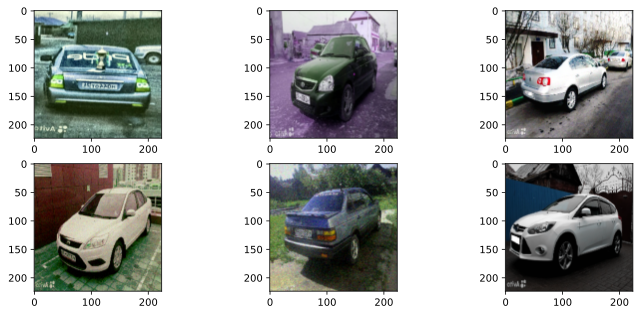

In [17]:
# Some examples of pictures in train_generator
x,y = train_generator.next()
print('Some examples of pictures from train_generator')
plt.figure(figsize=(12,8))

for i in range(0,6):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

Some examples of pictures from test_generator


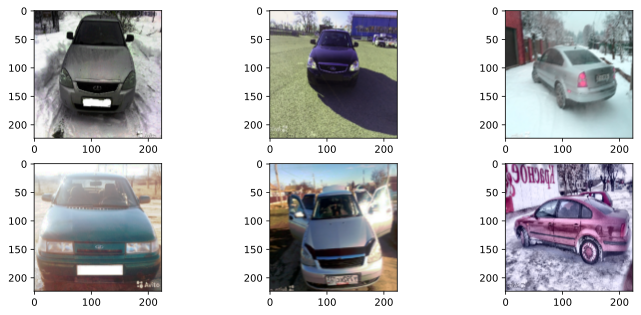

In [18]:
x,y = test_generator.next()
print('Some examples of pictures from test_generator')
plt.figure(figsize=(12,8))

for i in range(0,6):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

## Step 1

In [18]:
step_num = 1

# Creating model & compile model
model = ModelForTrain(config=config).build_model()

model.compile(loss=config.loss_compile, 
              optimizer=optimizers.Adam(learning_rate=config.LR), 
              metrics=[config.metric_compile])

Number of model layers: 664
Number of trainable_variables in model: 6


In [ ]:
# evaluate model metric before model training (too long for time)
#eval_model(model, test_generator)

### Training

In [ ]:
# Define callbacks list
callbacks_list = callbacks(paths.PATH_BEST_MODEL, config)

# Training
history = model.fit(
        train_generator,
        steps_per_epoch = len(train_generator), # train_generator.samples//train_generator.batch_size, #
        validation_data = test_generator,
        validation_steps = len(test_generator), # test_generator.samples//test_generator.batch_size, #
        epochs = config.EPOCHS,
        callbacks = callbacks_list
)

# save model and weights of model
save_model(paths, config, model, step_num)

In [ ]:
# print model train history
plot_history(history, paths.PATH_OUTPUTS, step_num, is_save_fig=False)

In [ ]:
# evaluate model metric after step 1 model training (too long for time)
# eval_model(model, test_generator)

## Step 2

In [ ]:
# Change params to unfreeze layers
step_num = 2
config.LR = config.LR / 2                    # 0.0001 -> 0.00005
config.BATCH_SIZE = int(config.BATCH_SIZE/2) # 64    -> 32
config.EPOCHS = config.EPOCHS*2              # 5     -> 10
config.f_tune_coef = 2                       # 1     -> 2

In [ ]:
# Creating model & compile model
model = ModelForTrain(config=config).build_model()

model.compile(loss=config.loss_compile, 
              optimizer=optimizers.Adam(learning_rate=config.LR), 
              metrics=[config.metric_compile])

if os.path.isfile(os.path.join(paths.PATH_BEST_MODEL, config.best_model_name)):
    model.load_weights(os.path.join(paths.PATH_BEST_MODEL, config.best_model_name))
else:
    if os.path.isfile(os.path.join('..', 'models', f'weights_step_{step_num - 1}.hdf5')):
        model.load_weights(os.path.join('..', 'models', f'weights_step_{step_num - 1}.hdf5'))
        print(f'weights_step_{step_num - 1}.hdf5 loaded')

In [ ]:
# We redefine new generators cause BATCH_SIZE was changed in this step
GEN = DataGenerators(config=config, albument_transforms=AUGMENTATIONS)
train_generator = GEN.create_generator(subset='training')
test_generator = GEN.create_generator(subset='validation')
#test_sub_generator = GEN.create_test_sub_generator(sample_submission_df=sample_submission,
#                                                   generator=GEN.test_datagen)

In [ ]:
# Define callbacks list
callbacks_list = callbacks(paths.PATH_BEST_MODEL, config)

# Training
history = model.fit(
        train_generator,
        steps_per_epoch = len(train_generator), # train_generator.samples//train_generator.batch_size, #
        validation_data = test_generator,
        validation_steps = len(test_generator), # test_generator.samples//test_generator.batch_size, #
        epochs = config.EPOCHS,
        callbacks = callbacks_list
)

# save model and weights of model
save_model(paths, config, model, step_num)

In [ ]:
# print model train history
plot_history(history, paths.PATH_OUTPUTS, step_num, is_save_fig=False)

In [ ]:
# evaluate model metric after step 2 model training (too long for time)
# eval_model(model, test_generator)

## Step 3

In [ ]:
# Change params to unfreeze layers
step_num = 3
config.LR = 0.00005          # Don't change in this step
config.BATCH_SIZE = 32       # Don't change in this step
config.EPOCHS = 10           # Don't change in this step
config.f_tune_coef = 4       # 2 -> 4

In [ ]:
# Creating model & compile model
model = ModelForTrain(config=config).build_model()

model.compile(loss=config.loss_compile, 
              optimizer=optimizers.Adam(learning_rate=config.LR), 
              metrics=[config.metric_compile])

if os.path.isfile(os.path.join(paths.PATH_BEST_MODEL, config.best_model_name)):
    model.load_weights(os.path.join(paths.PATH_BEST_MODEL, config.best_model_name))
else:
    if os.path.isfile(os.path.join('..', 'models', f'weights_step_{step_num - 1}.hdf5')):
        model.load_weights(os.path.join('..', 'models', f'weights_step_{step_num - 1}.hdf5'))
        print(f'weights_step_{step_num - 1}.hdf5 loaded')

In [ ]:
# We DIN'T redefine new generators cause BATCH_SIZE or IMG_SIZE wan't changed in this step
# just reset or load again
GEN = DataGenerators(config=config, albument_transforms=AUGMENTATIONS)
train_generator = GEN.create_generator(subset='training')
test_generator = GEN.create_generator(subset='validation')
#test_sub_generator = GEN.create_test_sub_generator(sample_submission_df=sample_submission,
#                                                   generator=GEN.test_datagen)

In [ ]:
# Define callbacks list
callbacks_list = callbacks(paths.PATH_BEST_MODEL, config)

# Training
history = model.fit(
        train_generator,
        steps_per_epoch = len(train_generator), # train_generator.samples//train_generator.batch_size, #
        validation_data = test_generator,
        validation_steps = len(test_generator), # test_generator.samples//test_generator.batch_size, #
        epochs = config.EPOCHS,
        callbacks = callbacks_list
)

# save model and weights of model
save_model(paths, config, model, step_num)

In [ ]:
# print model train history
plot_history(history, paths.PATH_OUTPUTS, step_num, is_save_fig=False)

In [ ]:
# evaluate model metric after step 3 model training (too long for time)
# eval_model(model, test_generator)

## Step 4

In [ ]:
# Change params to unfreeze layers
step_num = 4
config.LR = config.LR/5                       # 0.00005 -> 0.00001
config.BATCH_SIZE = int(config.BATCH_SIZE/2)  # 32      -> 16
config.EPOCHS = 10                            # Don't change in this step
config.train_all_base_layers = True           # Train all base layers
#config.f_tune_coef                           # Don't use cause train_all_base_layers = True

In [ ]:
# Creating model & compile model
model = ModelForTrain(config=config).build_model()

model.compile(loss=config.loss_compile, 
              optimizer=optimizers.Adam(learning_rate=config.LR), 
              metrics=[config.metric_compile])

if os.path.isfile(os.path.join(paths.PATH_BEST_MODEL, config.best_model_name)):
    model.load_weights(os.path.join(paths.PATH_BEST_MODEL, config.best_model_name))
else:
    if os.path.isfile(os.path.join('..', 'models', f'weights_step_{step_num - 1}.hdf5')):
        model.load_weights(os.path.join('..', 'models', f'weights_step_{step_num - 1}.hdf5'))
        print(f'weights_step_{step_num - 1}.hdf5 loaded')

In [ ]:
# Check the trainable status of the individual layers
#for layer in model.layers:
#    print(layer, layer.trainable) 

In [ ]:
# We redefine new generators cause BATCH_SIZE was changed in this step
GEN = DataGenerators(config=config, albument_transforms=AUGMENTATIONS)
train_generator = GEN.create_generator(subset='training')
test_generator = GEN.create_generator(subset='validation')
#test_sub_generator = GEN.create_test_sub_generator(sample_submission_df=sample_submission,
#                                                   generator=GEN.test_datagen)

In [ ]:
# Define callbacks list
callbacks_list = callbacks(paths.PATH_BEST_MODEL, config)

# Training
history = model.fit(
        train_generator,
        steps_per_epoch = len(train_generator), # train_generator.samples//train_generator.batch_size, #
        validation_data = test_generator,
        validation_steps = len(test_generator), # test_generator.samples//test_generator.batch_size, #
        epochs = config.EPOCHS,
        callbacks = callbacks_list
)

# save model and weights of model
save_model(paths, config, model, step_num)

In [ ]:
# print model train history
plot_history(history, paths.PATH_OUTPUTS, step_num, is_save_fig=False)

In [ ]:
# evaluate model metric after step 4 model training (too long for time)
# eval_model(model, test_generator)

## Step 5 + 6
#### We can't to train model during 20 epochs in one step so we try to train 2 steps with 10 epoch each.
#### If you can to train 20 epoch without stopping train, change: config.EPOCHS = 20 and skip step 6

In [ ]:
# Change params to fine-tune
step_num = 5
config.LR = 0.00001                            # Don't change in this step
config.BATCH_SIZE = 4                          # 16 -> 4
config.EPOCHS = 10                             # Don't change in this step | was 8 epoch
config.train_all_base_layers = True            # Train all base layers
#config.f_tune_coef                            # Don't use cause train_all_base_layers = True
config.IMG_SIZE = 448                          # 224 -> 448
input_shape = (config.IMG_SIZE, config.IMG_SIZE, config.IMG_CHANNELS)

In [ ]:
# Creating model & compile model
model = ModelForTrain(config=config).build_model()

model.compile(loss=config.loss_compile, 
              optimizer=optimizers.Adam(learning_rate=config.LR), 
              metrics=[config.metric_compile])

if os.path.isfile(os.path.join(paths.PATH_BEST_MODEL, config.best_model_name)):
    model.load_weights(os.path.join(paths.PATH_BEST_MODEL, config.best_model_name))
else:
    if os.path.isfile(os.path.join('..', 'models', f'weights_step_{step_num - 1}.hdf5')):
        model.load_weights(os.path.join('..', 'models', f'weights_step_{step_num - 1}.hdf5'))
        print(f'weights_step_{step_num - 1}.hdf5 loaded')

In [ ]:
# Creation new augmentations: we try to decrease changes in pics to produce more fine tune
AUGMENTATIONS = albumentations.Compose([
    albumentations.CLAHE(p=0.25, clip_limit=(1, 10), tile_grid_size=(10, 10)),
    albumentations.ChannelShuffle(p=0.25),
    albumentations.Equalize(p=0.25, mode='cv', by_channels=True),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.MotionBlur(p=0.25, blur_limit=(3, 7)),
    albumentations.RGBShift(p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1),
    ],p=0.5),
    albumentations.Rotate(p=0.5, limit=(-5, 5), interpolation=2, border_mode=2)
])

In [ ]:
# Creation new data generators due to IMG_SIZE increase and BATCH_SIZE changes
GEN = DataGenerators(config=config, albument_transforms=AUGMENTATIONS)
train_generator = GEN.create_generator(subset='training')
test_generator = GEN.create_generator(subset='validation')
#test_sub_generator = GEN.create_test_sub_generator(sample_submission_df=sample_submission,
#                                                   generator=GEN.test_datagen)

In [ ]:
# Define callbacks list
callbacks_list = callbacks(paths.PATH_BEST_MODEL, config)

# Training
history = model.fit(
        train_generator,
        steps_per_epoch = len(train_generator), # train_generator.samples//train_generator.batch_size, #
        validation_data = test_generator,
        validation_steps = len(test_generator), # test_generator.samples//test_generator.batch_size, #
        epochs = config.EPOCHS,
        callbacks = callbacks_list
)

# save model and weights of model
save_model(paths, config, model, step_num)

In [ ]:
# print model train history
plot_history(history, paths.PATH_OUTPUTS, step_num, is_save_fig=False)

In [ ]:
# evaluate model metric after step 5 model training (too long for time)
# eval_model(model, test_generator)

## Step 6

In [ ]:
# We change params cause you may load model from this step
step_num = 6                                   # was 6 epoch in best result
config.LR = 0.00001                            # Don't change in this step
config.BATCH_SIZE = 4                          # Don't change in this step
config.EPOCHS = 10                             # Don't change in this step | was 6 epoch
config.train_all_base_layers = True            # Train all base layers
#config.f_tune_coef                            # Don't use cause train_all_base_layers = True
config.IMG_SIZE = 448                          # 224 -> 448
input_shape = (config.IMG_SIZE, config.IMG_SIZE, config.IMG_CHANNELS)

In [ ]:
# Creating model & compile model cause you may load model from this step
model = ModelForTrain(config=config).build_model()

model.compile(loss=config.loss_compile, 
              optimizer=optimizers.Adam(learning_rate=config.LR), 
              metrics=[config.metric_compile])

if os.path.isfile(os.path.join(paths.PATH_BEST_MODEL, config.best_model_name)):
    model.load_weights(os.path.join(paths.PATH_BEST_MODEL, config.best_model_name))
else:
    if os.path.isfile(os.path.join('..', 'models', f'weights_step_{step_num - 1}.hdf5')):
        model.load_weights(os.path.join('..', 'models', f'weights_step_{step_num - 1}.hdf5'))
        print(f'weights_step_{step_num - 1}.hdf5 loaded')

In [ ]:
# Creation augmentations: cause you may load model from this step
AUGMENTATIONS = albumentations.Compose([
    albumentations.CLAHE(p=0.25, clip_limit=(1, 10), tile_grid_size=(10, 10)),
    albumentations.ChannelShuffle(p=0.25),
    albumentations.Equalize(p=0.25, mode='cv', by_channels=True),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.MotionBlur(p=0.25, blur_limit=(3, 7)),
    albumentations.RGBShift(p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1),
    ],p=0.5),
    albumentations.Rotate(p=0.5, limit=(-5, 5), interpolation=2, border_mode=2)
])

In [ ]:
# Creation new data generators cause you may load model from this step
GEN = DataGenerators(config=config, albument_transforms=AUGMENTATIONS)
train_generator = GEN.create_generator(subset='training')
test_generator = GEN.create_generator(subset='validation')
#test_sub_generator = GEN.create_test_sub_generator(sample_submission_df=sample_submission,
#                                                   generator=GEN.test_datagen)

In [ ]:
# Define callbacks list
callbacks_list = callbacks(paths.PATH_BEST_MODEL, config)

# Training
history = model.fit(
        train_generator,
        steps_per_epoch = len(train_generator), # train_generator.samples//train_generator.batch_size, #
        validation_data = test_generator,
        validation_steps = len(test_generator), # test_generator.samples//test_generator.batch_size, #
        epochs = config.EPOCHS,
        callbacks = callbacks_list
)

# save model and weights of model
save_model(paths, config, model, step_num)

In [ ]:
# print model train history
plot_history(history, paths.PATH_OUTPUTS, step_num, is_save_fig=False)

In [ ]:
# evaluate model metric after step 6 model training (too long for time)
# eval_model(model, test_generator)

## Step 7
#### If you can to train 20 epoch without stopping train, change: config.EPOCHS = 20

In [19]:
# Change params to fine-tune
step_num = 7
config.LR = 1e-6
config.BATCH_SIZE = 4               # Don't change in this step
config.EPOCHS = 10                  # Don't change in this step | was 8 epoch
config.train_all_base_layers = True # Train all base layers
#config.f_tune_coef                 # Don't use cause train_all_base_layers = True
config.IMG_SIZE = 448               # Don't change in this step
input_shape = (config.IMG_SIZE, config.IMG_SIZE, config.IMG_CHANNELS)  # Don't change in this step from previous step

In [20]:
# Creating model & compile model
model = ModelForTrain(config=config).build_model()

model.compile(loss=config.loss_compile, 
              optimizer=optimizers.Adam(learning_rate=config.LR), 
              metrics=[config.metric_compile])

if os.path.isfile(os.path.join(paths.PATH_BEST_MODEL, config.best_model_name)):
    model.load_weights(os.path.join(paths.PATH_BEST_MODEL, config.best_model_name))
else:
    if os.path.isfile(os.path.join('..', 'models', f'weights_step_{step_num - 1}.hdf5')):
        model.load_weights(os.path.join('..', 'models', f'weights_step_{step_num - 1}.hdf5'))
        print(f'weights_step_{step_num - 1}.hdf5 loaded')

Number of model layers: 664
Number of trainable_variables in model: 588
weights_step_6.hdf5 loaded


In [21]:
# Augmentations and don't change

# Creation new data generators due to IMG_SIZE increase and BATCH_SIZE changes
GEN = DataGenerators(config=config, albument_transforms=AUGMENTATIONS)
train_generator = GEN.create_generator(subset='training')
test_generator = GEN.create_generator(subset='validation')
#test_sub_generator = GEN.create_test_sub_generator(sample_submission_df=sample_submission,
#                                                   generator=GEN.test_datagen)

Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.


In [22]:
# Decrease patience from 3 to 2 in ReduceLROnPlateau callback
config.patience_reduce_plteau = 2

# Define callbacks list
callbacks_list = callbacks(paths.PATH_BEST_MODEL, config)

# Training
history = model.fit(
        train_generator,
        steps_per_epoch = len(train_generator), # train_generator.samples//train_generator.batch_size, #
        validation_data = test_generator,
        validation_steps = len(test_generator), # test_generator.samples//test_generator.batch_size, #
        epochs = config.EPOCHS,
        callbacks = callbacks_list
)

# save model and weights of model
save_model(paths, config, model, step_num)

In [ ]:
# print model train history
plot_history(history, paths.PATH_OUTPUTS, step_num, is_save_fig=False)

In [ ]:
# evaluate model metric after step 7 model training (too long for time)
# eval_model(model, test_generator)

## Make predictions

In [21]:
# Last params to create model and load trained weights
config.LR = 1e-6
config.BATCH_SIZE = 4
config.EPOCHS = 10
#config.f_tune_coef    # Don't use cause train_all_base_layers = True
config.train_all_base_layers = True
config.IMG_SIZE = 448
input_shape = (config.IMG_SIZE, config.IMG_SIZE, config.IMG_CHANNELS)

In [22]:
# Creation new data generator to predict
AUGMENTATIONS=None
GEN = DataGenerators(config=config, albument_transforms=AUGMENTATIONS)
generator_for_pred = GEN.test_datagen
test_sub_generator = GEN.create_test_sub_generator(sample_submission_df=sample_submission, 
                                                   generator=generator_for_pred)
filenames_from_sub_gen = test_sub_generator.filenames
label_map = get_label_map(paths)

Found 6675 validated image filenames.


In [23]:
# Creating model & compile model
model = ModelForTrain(config=config).build_model()

model.compile(loss=config.loss_compile, 
              optimizer=optimizers.Adam(learning_rate=config.LR), 
              metrics=[config.metric_compile])

if os.path.isfile(os.path.join(paths.PATH_BEST_MODEL, config.best_model_name)):
    model.load_weights(os.path.join(paths.PATH_BEST_MODEL, config.best_model_name))

Number of model layers: 672
Number of trainable_variables in model: 588


In [ ]:
# Make predictions and submission
predictions = make_predictions(test_sub_generator, model, label_map)

submission = make_submission(filenames_with_dir=filenames_from_sub_gen, 
                             predictions=predictions)

## Make predictions with TTA

In [17]:
# Last params to create model and load trained weights
config.LR = 1e-6
config.BATCH_SIZE = 4
config.EPOCHS = 10
#config.f_tune_coef    # Don't use cause train_all_base_layers = True
config.train_all_base_layers = True
config.IMG_SIZE = 448
input_shape = (config.IMG_SIZE, config.IMG_SIZE, config.IMG_CHANNELS)

In [18]:
# For TTA we use only base aumentations to give to a model a little help by small changes 
# Use AUGMENTATIONS=None for predictions without AUGMENTATIONS.
AUGMENTATIONS = albumentations.Compose([
        albumentations.CLAHE(p=0.25, clip_limit=(1, 10), tile_grid_size=(10, 10)),
        albumentations.ChannelShuffle(p=0.25),
        albumentations.Equalize(p=0.25, mode='cv', by_channels=True),
        albumentations.HorizontalFlip(p=0.5),
        albumentations.Rotate(p=0.5, limit=(-5, 5), interpolation=2, border_mode=2)
    ])

In [19]:
# Creation new data generator to test_sub_datagen
GEN = DataGenerators(config=config, albument_transforms=AUGMENTATIONS)
generator_for_TTA = GEN.train_datagen # without TTA use: generator = GEN.test_datagen
test_sub_generator = GEN.create_test_sub_generator(sample_submission_df=sample_submission, 
                                                   generator=generator_for_TTA)
filenames_from_sub_gen = test_sub_generator.filenames
label_map = get_label_map(paths)
# label_map = GEN.create_generator(subset='training').class_indices

Found 6675 validated image filenames.


In [20]:
# Creating model & compile model
model = ModelForTrain(config=config).build_model()

model.compile(loss=config.loss_compile, 
              optimizer=optimizers.Adam(learning_rate=config.LR), 
              metrics=[config.metric_compile])

if os.path.isfile(os.path.join(paths.PATH_BEST_MODEL, config.best_model_name)):
    model.load_weights(os.path.join(paths.PATH_BEST_MODEL, config.best_model_name))
    print(f'weights_step_{step_num - 1}.hdf5 loaded')

Number of model layers: 672
Number of trainable_variables in model: 588


In [ ]:
# Make predictions and submission with TTA
predictions_with_tta = make_tta(config, test_sub_generator, model, label_map)

submission = make_submission(filenames_with_dir=filenames_from_sub_gen, 
                             predictions=predictions_with_tta)

In [ ]:
# Clean paths.PATH_DATA_TRAIN
#import shutil
#shutil.rmtree(paths.PATH_DATA_TRAIN)

**Что еще можно сделать для улучшения модели!**


→ Попробовать другие архитектуры сетей, например, SOTA на ImageNet позднее B6, дающие бОльшую точность.

→ Поэкспериментировать с архитектурой «головы».

→ Попробовать больше эпох на 5 этапе обучения.

→ Использовать разные техники управления Learning Rate, например Sheduler, но он требует большего времени и исключение ограничения на сессию.

→ Использовать внешние датасеты для дообучения модели.

→ Обернуть модель в сервис на Flask (чтобы на практике отследить особенности внедрения DL-моделей в продакшн).